# Script to plot EKE and wind stress over a chosen box

This script is designed so that we can select an individual box and compute:
 * The EKE for each member over that box
 * The ensemble mean EKE over that box
 * The wind stress over that box
 * The lagged cross-correlation between EKE and stress
 
It is slow, even distributed over multiple cores, so be patient!

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import xarray as xr
import numpy as np
import IPython.display
import pandas as pd
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import os 

from scipy import stats


import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client()
client

<Client: 'tcp://127.0.0.1:32800' processes=4 threads=8, memory=33.67 GB>

In [3]:
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=1.0)

In [4]:
HardDisk = '/g/data/v45/amh157/OCCIPUT/'
EnsembleDir = 'geouv/'

In [5]:
def PlotMap(ax_map, lon1, lon2, lat1, lat2, col):

    ax_map.set_extent([-287, 73, -80, -30], crs=ccrs.PlateCarree())
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax_map.set_boundary(circle, transform=ax_map.transAxes)
    ax_map.add_feature(land_50m)
    ax_map.gridlines()

    ## Load EKE climatology
    climfilename = HardDisk+EnsembleDir+'eke_climatology.nc'
    eke_month = xr.open_dataset(climfilename).EKE
    p1 = eke_month.mean('month').plot(ax=ax_map,cmap=cm.cm.speed,vmax=0.16,add_colorbar=False,transform=ccrs.PlateCarree())
    plt.title('Transient KE Climatology')

    # Add colorbar
    ax_col = plt.axes([0.02,0.05,0.01,0.3])
    plt.colorbar(p1,cax=ax_col,orientation='vertical',extend='max')

    ## Add lines to show our region of interest on the map
    ax_map.plot([lon1, lon2, lon2, lon1, lon1],[lat1,lat1,lat2,lat2,lat1],
            color=col,linewidth=2,transform=ccrs.PlateCarree())

In [6]:
def PlotSingleBox(desc, lon1, lon2, lat1, lat2):
    plt.figure(figsize=(12, 5))

    ## Other things to set
    nfiles = 50
    nn=0
    col = 'r'
    start = pd.datetime(1980,1,1) ## start time for plotting
    end = pd.datetime(2014,12,31)

    ## First, make axes for the map, and plot EKE Climatology
    ax_map = plt.axes([0.05,0.1,0.33,0.8],projection=ccrs.SouthPolarStereo())
    PlotMap(ax_map, lon1, lon2, lat1, lat2, col)

    ## Axes to plot EKE
    ax_eke = plt.axes([0.46,0.12,0.46,0.76])
    eke_results = []
    for ii in range(1,nfiles+1):
        nn+=1
        i00 = '%03d' % ii
        Member = 'e'+i00
        ekefilename = HardDisk+EnsembleDir+Member+'/eke_'+i00+'_????.nc'
        
        eke = xr.open_mfdataset(ekefilename).EKE
    
        eke = eke.sel(lon=slice(lon1,lon2)).sel(lat=slice(lat1,lat2)).mean('lon').mean('lat')
        eke = eke.rolling(time=12,center=True).mean()
        eke.plot(ax=ax_eke,color=[0.5, 0.5, 0.5],linewidth=0.5)
    
        result = {'ii': ii,'eke': eke}
        eke_results.append(result)
    
        if ii==1:
            eke_sum = eke
        else:
            eke_sum = eke_sum + eke
        #print(ekefilename)
                        
    eke_sum = eke_sum.load()/nn
    eke_sum.plot(ax=ax_eke,color=col,linewidth=2)
    ax_eke.set_xlabel('Year')
    ax_eke.set_ylabel('Transient KE (m$^2$/s$^2$)',color=col)
    #ax_eke.set_ylim(ymax=0.013)
    ax_eke.tick_params('y',labelcolor=col)
    ax_eke.set_xlim([start,end])

    # Compute variance ratios from saved results
    for result in eke_results:
        ii = result['ii']
        eke = result['eke']
    
        if ii==1:
            eke_var = (eke - eke_sum)**2
        else:
            eke_var = eke_var + (eke - eke_sum)**2
        
    eke_var = eke_var.load()/nn
    sigma2 = np.var(eke_sum)  
    epsilon2 = eke_var.mean('time')
    ratio = (epsilon2/(epsilon2+sigma2))
    print(desc+' R_i = %0.2f'%ratio.values)

    ## Axes to plot the wind
    ax_tau=ax_eke.twinx()
    taufilename = HardDisk+EnsembleDir+'tau/'+'tau_????.nc'
    tau = xr.open_mfdataset(taufilename).tau
    
    tau = tau.sel(lon=slice(lon1,lon2)).sel(lat=slice(lat1,lat2)).mean('lon').mean('lat')
    tau = tau.rolling(time=12,center=True).mean().load()
    tau.plot(ax=ax_tau,color='k',linestyle='--',linewidth=2)
    #ax_tau.set_ylim(ymin=0.08)
    ax_tau.set_ylabel('Wind Stress (N/m$^2$)')
    ax_tau.set_xlim([start,end])

    ## Axes to plot lagged correlation
    ax_corr = plt.axes([0.5,0.68,0.14,0.26])
    ekep = eke_sum[6:-6] - eke_sum.mean()
    taup = tau[6:-6] - tau.mean()
    #coef = cor(taup,ekep)
    coef, signif = pearsoncor(taup,ekep)
    lag = coef.argmax() 
    #print(coef)
    #print(signif)
    ax_corr.plot(coef,linewidth=2)
    print('Correlations: %d months, %0.2f, %0.2f'%(lag, coef[lag], signif[lag]))
    
    ax_corr.plot(lag,coef[lag],'.')

    ax_corr.set_xlim([0,48])
    ax_corr.set_ylim([0,0.82])
    ax_corr.set_xticks([0, 12, 24, 36])
    ax_corr.set_title('Lag Correlation')
    ax_corr.set_xlabel('Months')
    #ax_corr.set_ylabel('Correlation')
    ax_corr.grid()

    FigureFile = 'figures/'+desc+'.png'
    plt.savefig(FigureFile)

In [7]:
#Josue's correlation function -- one-sided lags.
#Assumes that y1 is leading
def cor(y1, y2):
   n = len(y1)
   nc = int(n/3.5)

   y1t = y1-np.mean(y1)
   y2t = y2-np.mean(y2)    

   cor = np.zeros(nc)
   for j in np.arange(0, nc):
       moved=np.roll(y1t, j)
       moved[:j]=np.nan
       #cor[j] = np.nanmean(moved*y2)/np.sqrt(np.nanmean(y1**2)*np.nanmean(y2**2))
       cor[j] = np.nanmean(moved*y2t)/np.sqrt(np.nanmean(y1t**2*y2t**2))
   return cor

In [8]:
def pearsoncor(y1, y2):
    ## Looking for lagged correlations between two timeseries
    ## Assumes y1 is leading
    ## Avoid end effects by using only first 2/3rds of timeseries
    n = len(y1)
    nc = int(n/3.5)
    
    # De-mean both timeseries
    y1t = y1-np.mean(y1)
    y2t = y2-np.mean(y2)    

    cor = np.zeros(nc)
    sig = np.zeros(nc)
    for j in np.arange(0, nc):
        x1t = np.roll(y1t, j)[j:]#y1t[:-j]
        x2t = y2t[j:]
        cor[j], sig[j] = stats.pearsonr(x1t, x2t)
    return cor, sig

# EKE for the entire Southern Ocean


Entire_Southern_Ocean R_i = 0.72
Correlations: 7 months, 0.49, 0.00


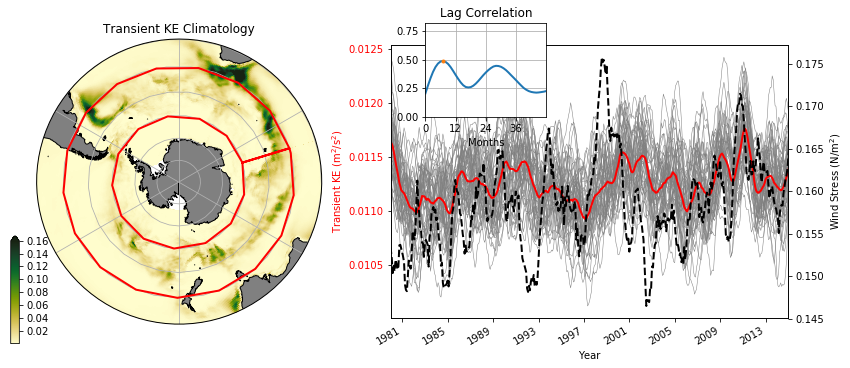

In [9]:
PlotSingleBox('Entire_Southern_Ocean',-287, 73, -60, -40)

# Looping around the Southern Ocean in 60° boxes

Southern_Ocean_Sector_0 R_i = 0.55
Correlations: 6 months, 0.64, 0.00
Southern_Ocean_Sector_1 R_i = 0.60
Correlations: 15 months, 0.50, 0.00
Southern_Ocean_Sector_2 R_i = 0.71
Correlations: 28 months, 0.17, 0.00
Southern_Ocean_Sector_3 R_i = 0.82
Correlations: 85 months, 0.28, 0.00
Southern_Ocean_Sector_4 R_i = 0.71
Correlations: 81 months, 0.24, 0.00
Southern_Ocean_Sector_5 R_i = 0.79
Correlations: 31 months, 0.32, 0.00


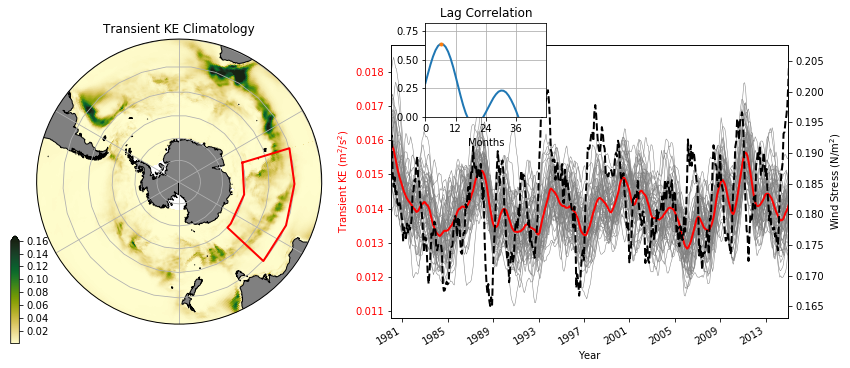

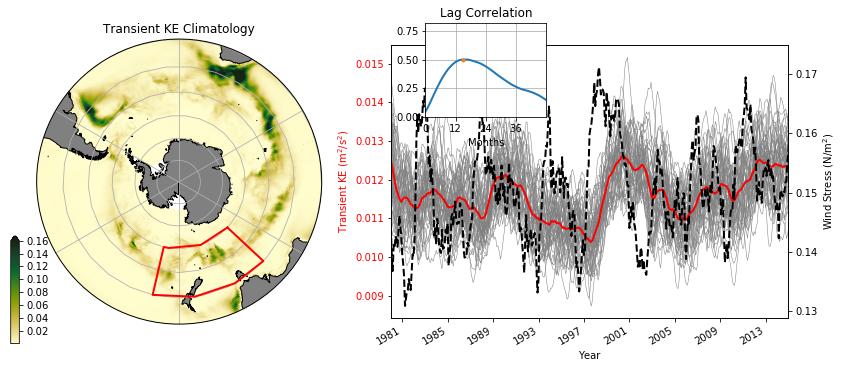

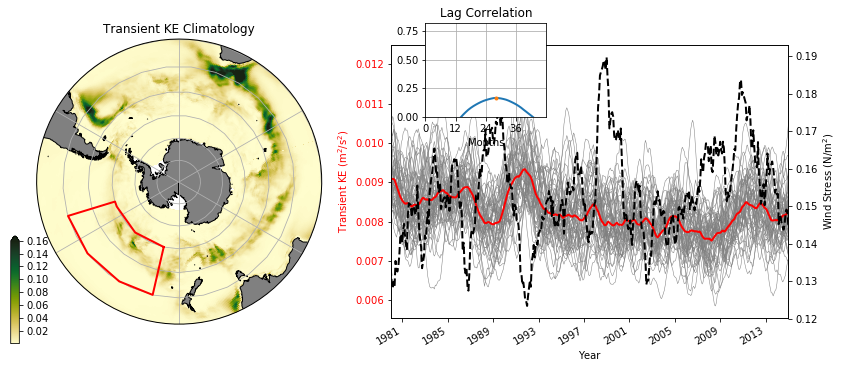

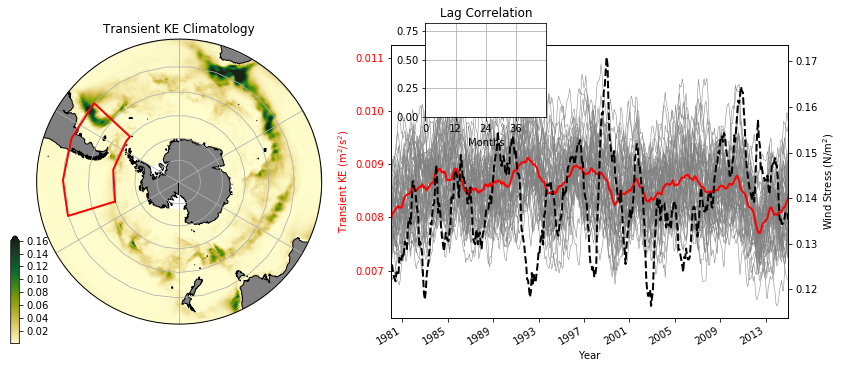

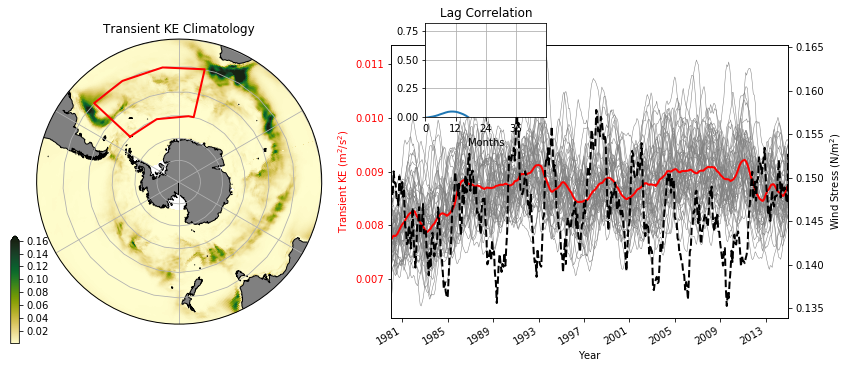

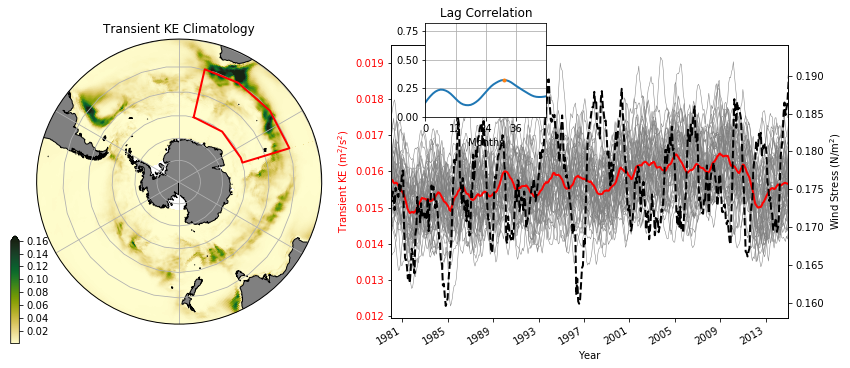

In [10]:
for ii in range(6):
    PlotSingleBox('Southern_Ocean_Sector_%d'%ii,-287+ii*60, -287+(ii+1)*60, -60, -40)

# Individual customised boxes

Agulhas_Rings R_i = 0.91
Correlations: 100 months, 0.33, 0.00
CPU times: user 7min 14s, sys: 31.3 s, total: 7min 46s
Wall time: 18min 26s


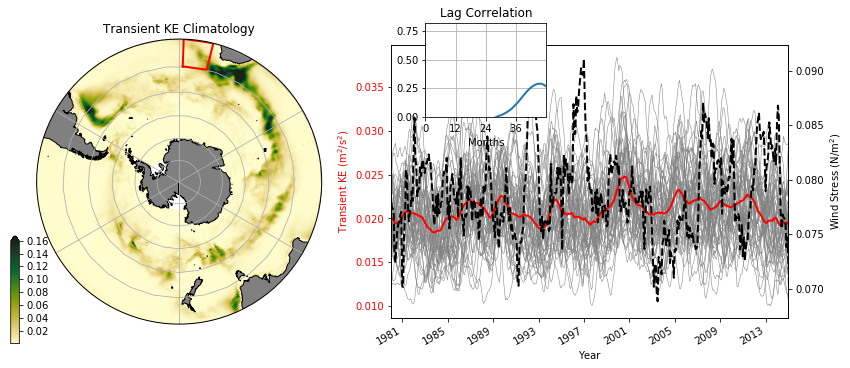

In [11]:
%%time
PlotSingleBox('Agulhas_Rings',2, 14, -40, -30)

Agulhas_Retroflection R_i = 0.84
Correlations: 99 months, 0.13, 0.02
CPU times: user 7min 11s, sys: 32.9 s, total: 7min 44s
Wall time: 17min 58s


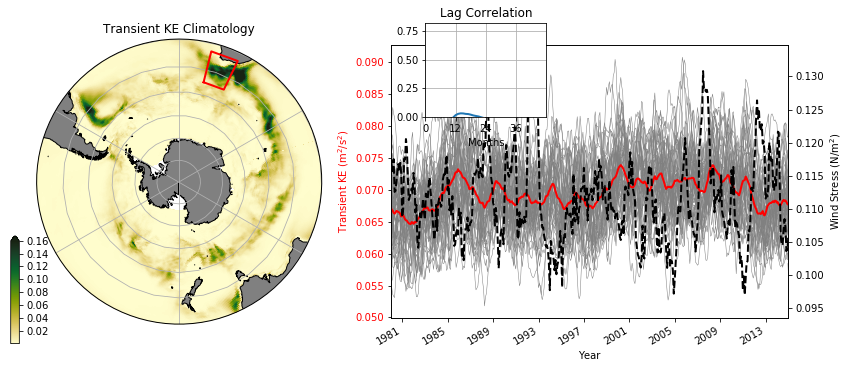

In [12]:
%%time
PlotSingleBox('Agulhas_Retroflection',14, 26, -45, -33)

Agulhas_Extension R_i = 0.88
Correlations: 122 months, 0.23, 0.00


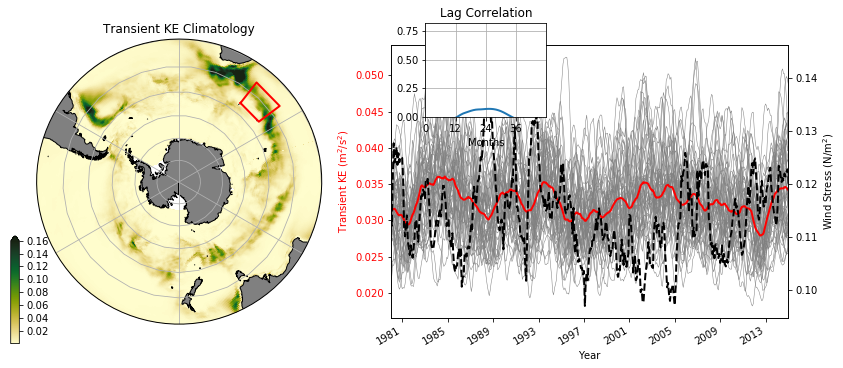

In [13]:
PlotSingleBox('Agulhas_Extension',38,  53, -46,  -36,)

NorthWest_Kerguelen_Plateau R_i = 0.89
Correlations: 38 months, 0.24, 0.00


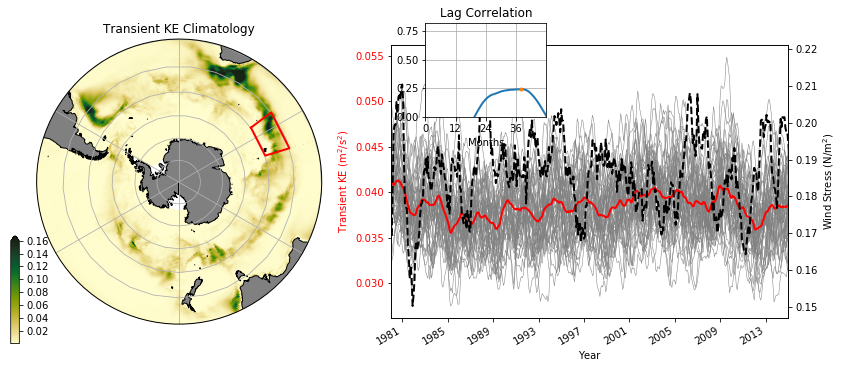

In [14]:
PlotSingleBox('NorthWest_Kerguelen_Plateau',53, 73, -50, -40)

North_Kerguelen_Plateau R_i = 0.85
Correlations: 122 months, 0.42, 0.00


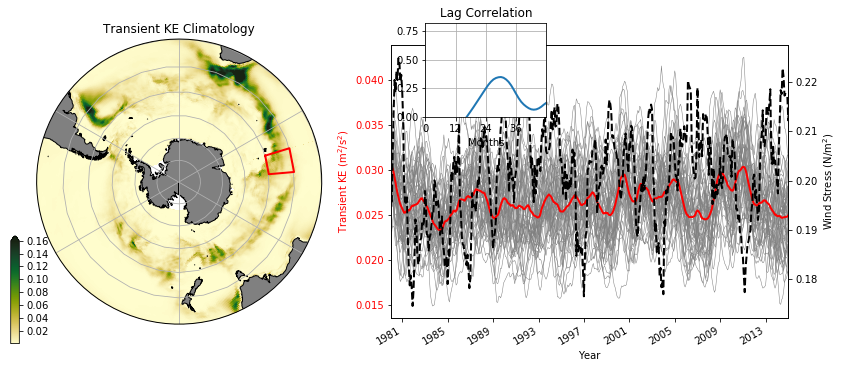

In [15]:
PlotSingleBox('North_Kerguelen_Plateau',-287, -275, -50, -40)

Kerguelen_Plateau R_i = 0.44
Correlations: 6 months, 0.80, 0.00


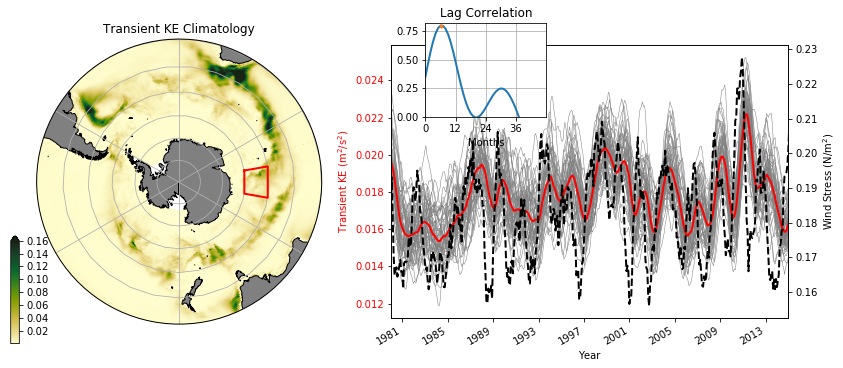

In [16]:
PlotSingleBox('Kerguelen_Plateau',-280, -260, -60, -50)

SouthEast_Indian_Ridge R_i = 0.82
Correlations: 85 months, 0.33, 0.00


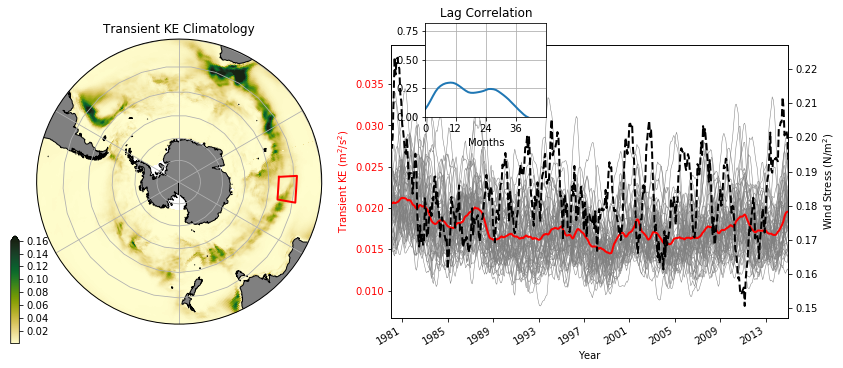

In [17]:
PlotSingleBox('SouthEast_Indian_Ridge',-273, -260, -46, -39)

SouthEast_Indian_Ridge R_i = 0.62
Correlations: 6 months, 0.54, 0.00


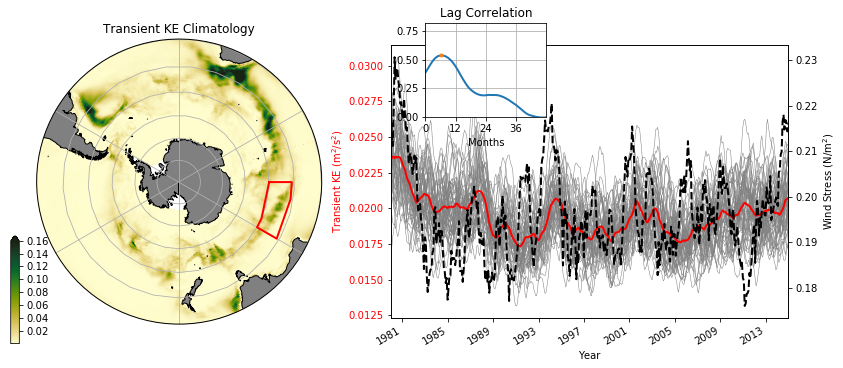

In [18]:
PlotSingleBox('SouthEast_Indian_Ridge',-270, -240, -50, -41)

Australian_Bight R_i = 0.88
Correlations: 7 months, 0.23, 0.00


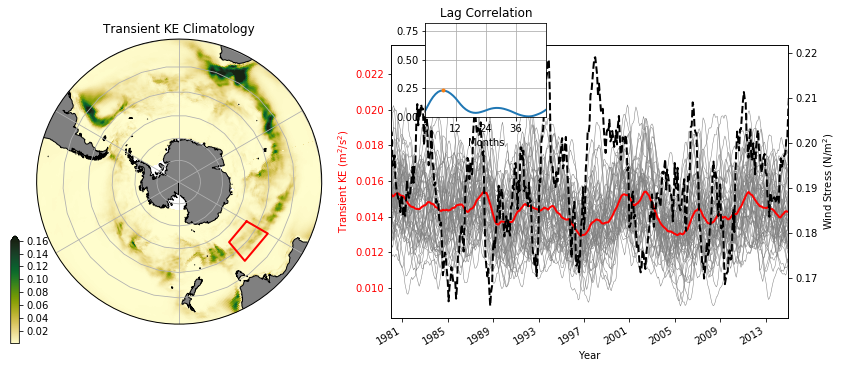

In [19]:
PlotSingleBox('Australian_Bight',-240, -220, -55, -45)

Macquarie_Ridge R_i = 0.71
Correlations: 11 months, 0.52, 0.00


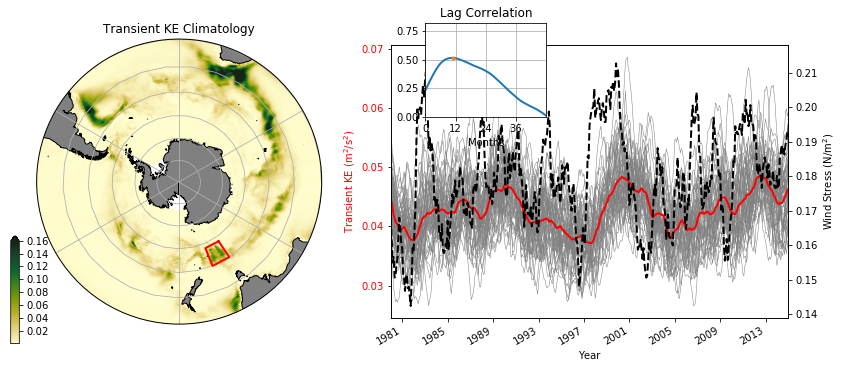

In [20]:
PlotSingleBox('Macquarie_Ridge',-214, -202, -58, -50)

Campbell_Plateau R_i = 0.91
Correlations: 26 months, 0.31, 0.00


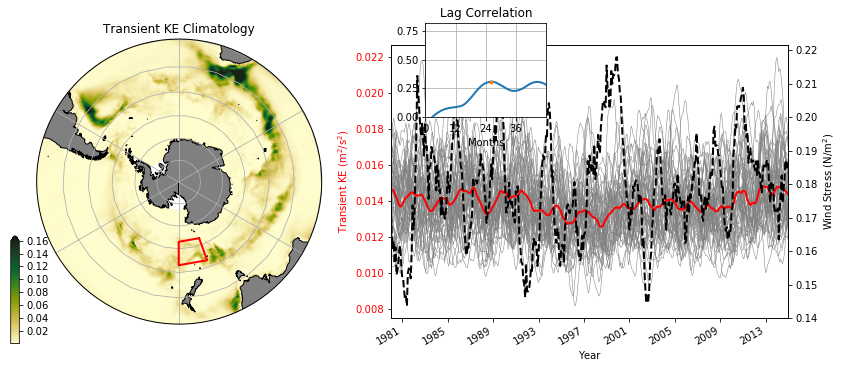

In [21]:
PlotSingleBox('Campbell_Plateau',-200, -180, -63, -53)

Chatham_Rise R_i = 0.68
Correlations: 10 months, 0.43, 0.00


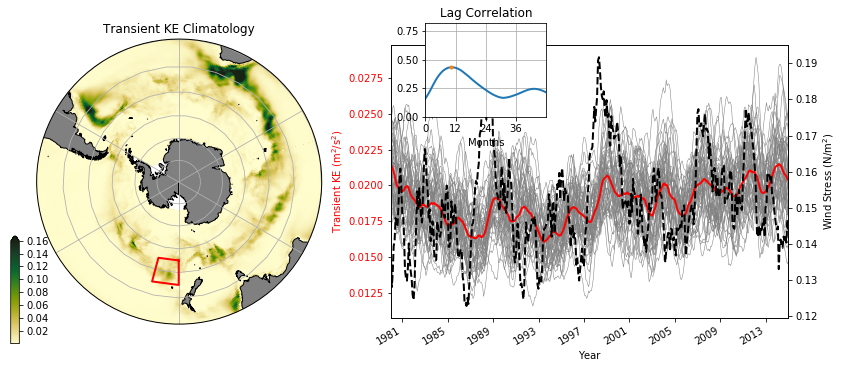

In [22]:
PlotSingleBox('Chatham_Rise',-180, -165, -55, -45)

Chatham_Downstream R_i = 0.72
Correlations: 13 months, 0.48, 0.00


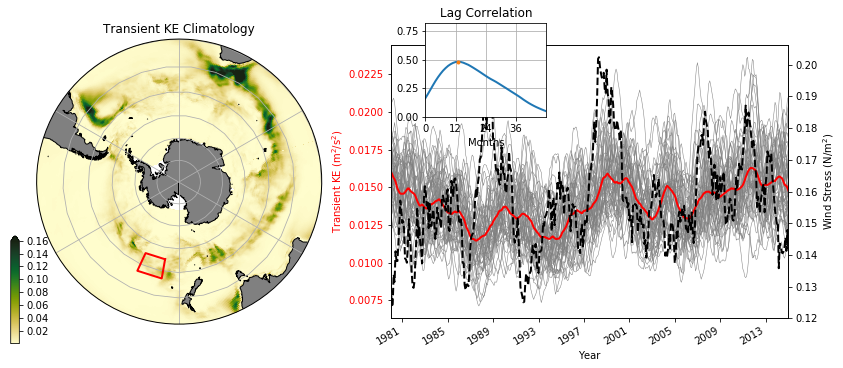

In [23]:
PlotSingleBox('Chatham_Downstream',-170, -155, -55, -47)

South_Pacific_Ridge R_i = 0.80
Correlations: 82 months, 0.19, 0.00


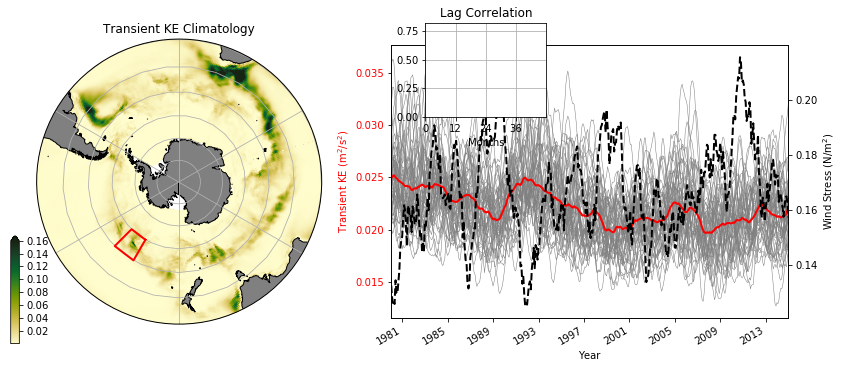

In [24]:
PlotSingleBox('South_Pacific_Ridge',-150, -135, -60, -50)

South_Pacific R_i = 0.72
Correlations: 16 months, 0.27, 0.00


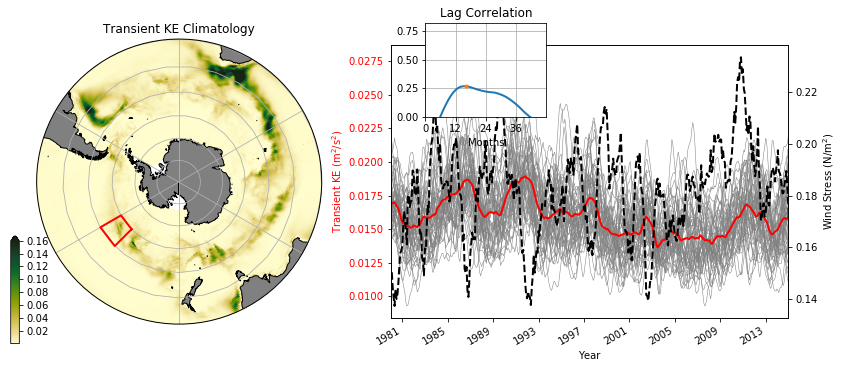

In [25]:
PlotSingleBox('South_Pacific',-135, -120, -60, -50)

SouthEast_Pacific R_i = 0.55
Correlations: 99 months, 0.25, 0.00


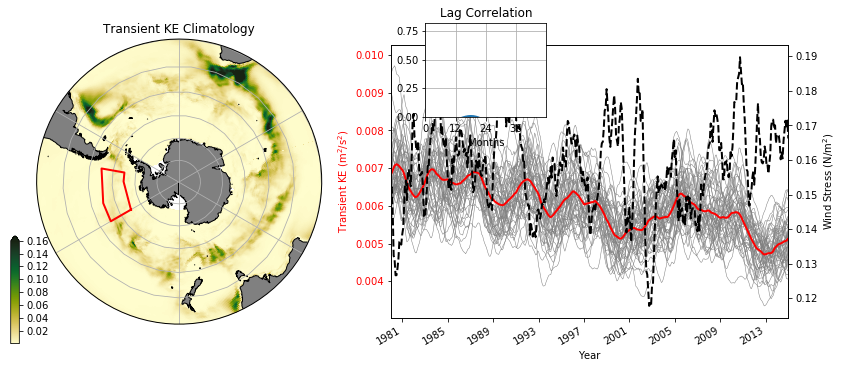

In [26]:
PlotSingleBox('SouthEast_Pacific',-120, -80, -65, -55)

Drake_Passage R_i = 0.73
Correlations: 85 months, 0.26, 0.00


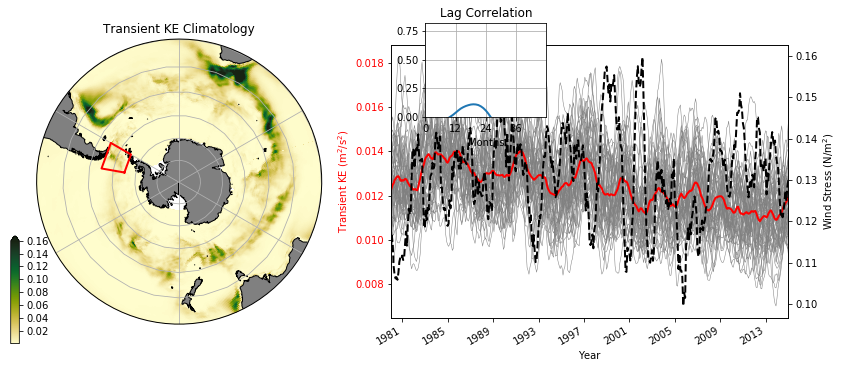

In [27]:
PlotSingleBox('Drake_Passage',-80, -60, -65, -55)

Drake_Passage_Downstream R_i = 0.83
Correlations: 39 months, 0.27, 0.00


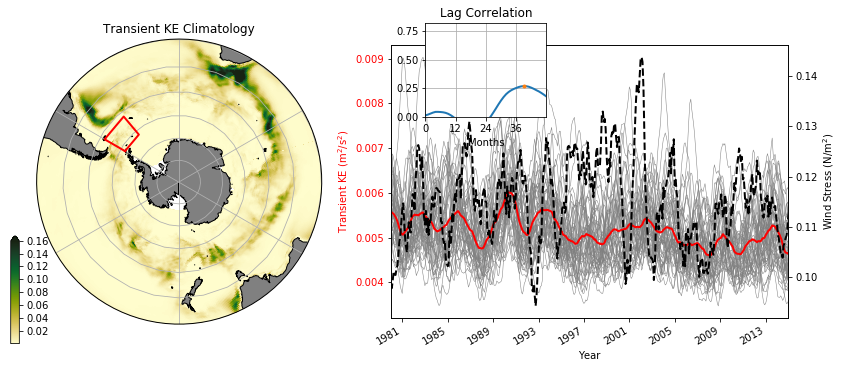

In [28]:
PlotSingleBox('Drake_Passage_Downstream',-60, -40, -62, -52)

Zapiola R_i = 0.70
Correlations: 13 months, 0.32, 0.00


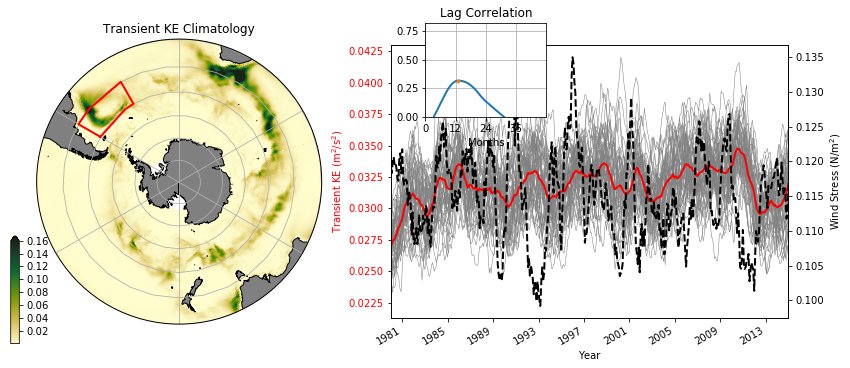

In [29]:
PlotSingleBox('Zapiola', -60, -30, -50, -40)

South_Atlantic R_i = 0.79
Correlations: 14 months, 0.31, 0.00


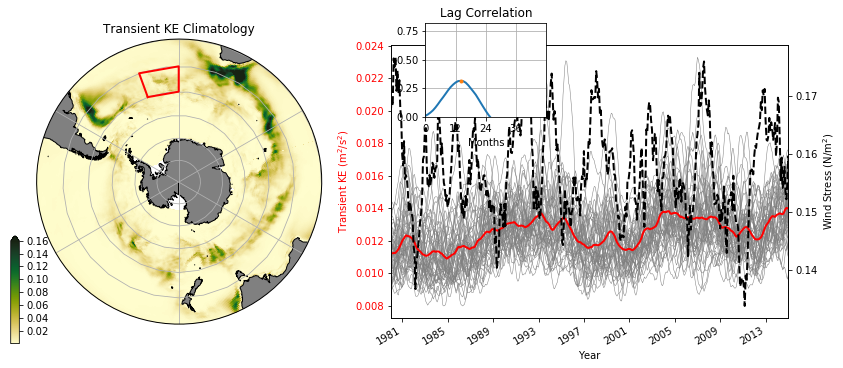

In [30]:
PlotSingleBox('South_Atlantic', -20, 0, -50, -40)